## Capital One - Case Study
##### By Rasesh Garg
gargrs@mail.uc.edu

# Case Study Layout

1. Overview
    1. Describing Problem and Approach
    2. Summarising Assumptions
    3. Defining variables    
2. Defining Functions
    1. Preparing Zillow Data
    2. Preparing Air BnB data
    3. Preparing combined data for Analysis
3. Analyzing
    1. Neighbourhood comparison
    2. Break even time
    3. Profitability
4. Findings and Conclusion
5. Future Steps

# Overview


#### Objective: To recommend zipcodes from the given zillow data in which AirBnB should invest for maximising profits

'Profit' can be split in two parts
1. Earnings from Rent post break even of the cost
2. Increase in the value of capital(house) over time

For this case study we will base our recommendation only on the first part i.e Earning from rent post the break even time of purchase and ignore the capital gains. 

#### Approach
Major steps involved to arrive at the right zipcodes are:

1. Forecast median cost for the year 2019 from Zillow data (for each zip code)
2. Aprroximate median Rent from each zip code from AirBnB data (post cleaning)
3. Calculate Break-even time(in years) for each zipcode 
4. Calculate cummulative profit through rentals post break even in the chosen time period for each zip code

#### Summarising Assumptions:

##### Major Assumptions involved are:
1. Mean of the monthly cost is taken to arrive at the yearly cost.
2. Rate of Increase in property prices is based on last 3 years (2015-2017)
3. Above rate is used to compound and forecast cost for the year 2019
4. Annual percent increase in rent is fixed and equal to the above rate 
5. Median size house corresponds to the median rent from the AirBnB data.

#### Defining Variables:
Variables are defined majorly to make the data processing functions dynamic.
Below is the description of these variables along with their current value



In [1]:
# 1. For preparing Zillow Data:

#Filters for outliers
max_cost = False    # Type - integer (in dollars). If False, mean+3*standard deviation will be taken
min_cost = False    # Type - integer (in dollars). If False, mean-3*standard deviation will be taken
city = 'New York'   # Type -string. 

#2. For Preparing AirBnB Data:
bedroom_count = 2  # Type - integer. Number of bedrooms in each listing

#Removing outliers
max_rent = 1500 # Type - integer (in dollars). If False, mean+3*standard deviation will be taken
min_rent = 20 # Type - integer (in dollars). If False, mean-3*standard deviation will be taken
property_types = False #Type- list of property_types. If False all property_types will be taken.

#3. For Analzing Data

occupancy_rate = 0.75 # Type - float. Avg occupancy rate per year. For yrly rent = 365*(price/night)*occupancy_rate    

# Defining Functions

To clean, combine and prepare data for final analysis. 

#### Importing Packages

In [2]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

#### Reading Data

Please update the path of the raw data before running.

In [3]:
#Define Path to the data in your PC
bnb = 'listings (2).csv.gz'  #For Air BnB data
zil = 'Zip_Zhvi_2bedroom.csv' #For Zillow data

In [4]:
#Reading Data
listings = pd.read_csv(bnb)
zillow = pd.read_csv(zil)

In [5]:
print('Size of zillow data ' + str(zillow.shape))
print('Size of listings data ' + str(listings.shape))

Size of zillow data (8946, 262)
Size of listings data (48895, 106)


In [6]:
listings.head(2)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2539,https://www.airbnb.com/rooms/2539,20190708031610,2019-07-09,Clean & quiet apt home by the park,Renovated apt home in elevator building.,"Spacious, renovated, and clean apt home, one b...",Renovated apt home in elevator building. Spaci...,none,Close to Prospect Park and Historic Ditmas Park,...,f,f,moderate,f,f,6,0,5,1,0.21
1,2595,https://www.airbnb.com/rooms/2595,20190708031610,2019-07-09,Skylit Midtown Castle,"Find your romantic getaway to this beautiful, ...","- Spacious (500+ft²), immaculate and nicely fu...","Find your romantic getaway to this beautiful, ...",none,Centrally located in the heart of Manhattan ju...,...,f,f,strict_14_with_grace_period,t,t,2,1,0,1,0.38


In [7]:
zillow.head(2)

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06
0,61639,10025,New York,NY,New York,New York,1,NaN,NaN,NaN,...,1374400,1364100,1366300,1354800.0,1327500,1317300,1333700,1352100,1390000,1431000
1,84654,60657,Chicago,IL,Chicago,Cook,2,167700.0,166400.0,166700.0,...,368600,370200,372300,375300.0,378700,381400,381800,382100,383300,385100


## Preparing Zillow Data

In [8]:
# zillow.isna().sum().sort_values(ascending = False)

In [9]:
def zillow_data(zillow, max_cost = max_cost, min_cost = min_cost):
    #Filtering city
    zillow = zillow.loc[zillow['City'] == city,:]

    #Melting table
    zillow = zillow.melt(id_vars = ['RegionID','RegionName','City','State','Metro','CountyName','SizeRank'], var_name = 'year_month', value_name = 'cost')
  
    #Adding year and month column
    zillow['year'] = [ i.split("-")[0] for i in zillow.year_month]
    zillow['month'] = [ i.split("-")[1] for i in zillow.year_month]
 
    # Filtering only required years
    zillow = zillow.loc[zillow.year.isin(['2015','2016','2017']), :]
   
    # Sorting
    zillow = zillow.sort_values(['RegionName','year','month'], ascending = False)

    #Removing outliers w.r.t cost
    if max_cost == False:
        cost_stdev_max = zillow.cost.mean()+3*zillow.cost.std() 
        zillow = zillow.loc[(zillow.cost.isnull()) | (zillow.cost <= cost_stdev_max),:]
    else:
        zillow = zillow.loc[(zillow.cost.isnull()) | (zillow.cost <= max_cost),:]

    if min_cost == False:
        cost_stdev_min = zillow.cost.mean()- 3*zillow.cost.std()
        zillow = zillow.loc[(zillow.cost.isnull()) | (zillow.cost >= cost_stdev_min),:]
    else:
        zillow = zillow.loc[(zillow.cost.isnull()) | (zillow.cost >= min_cost),:] 
          
    #Imputing cost to nearest non missing value
    zillow.cost = zillow.groupby('RegionName').cost.apply(lambda x : x.interpolate(method='nearest'))
        
    # Collating months to get yearly median price  (mean of the monthly prices)
    zillow = zillow.groupby(['RegionName','year']).aggregate({'CountyName': max, 'SizeRank': max,'cost': np.mean}).reset_index()
    
    # Computing Avg YoY% change based on the list- years
    zillow = zillow.pivot_table('cost', index = ['RegionName','CountyName','SizeRank'],columns = 'year').reset_index()
    zillow.columns = zillow.columns.rename('')
    zillow['YoY_change'] = 0.5*((zillow['2017']-zillow['2016'])/zillow['2016']) + 0.5*((zillow['2016']-zillow['2015'])/zillow['2015'])    
    
    #Estimating cost for year 2019 by using YoY change as the compound interest
    zillow['2019_cost'] = (zillow['2017'])*((1+zillow.YoY_change)**2)
    zillow['2019_cost'] = zillow['2019_cost'].astype(np.int)

    # Removing 2015 and 2017 prices
    zillow = zillow.drop(columns = ['2015','2016','2017','CountyName'])
    #zillow = zillow.drop(['2015','2016'], axis = 1)

    return zillow
    

In [10]:
# Running the above Function on our data
final_zillow = zillow_data(zillow)
#Viewing first 5 rows of Data
final_zillow.head(5)

,RegionName,SizeRank,YoY_change,2019_cost
0,10003,21,0.053380,2237581
1,10011,15,0.074001,2737778
2,10013,1744,0.019930,3354328
3,10014,379,0.054543,2750294
4,10021,190,0.074320,1981911


#### Describing above Data

Above data is filtered for New york and 2015-2017 data is used to calculate the YoY_change and 2019_cost

1. YoY_change : Weighted average of yearly change of cost from 2015-2017 (i.e last 3 years of given data)
2. 2019_cost: Calculated after compounding 2017 cost annually once for 2 years at YoY_change rate, calculated above

Note: Yearly cost is taken as mean of the monthly cost in the given year. This cost is the purchase price of listing and is a one time investment. 

## Preparing AirBnB Data

Below is the function to clean and prepare the AirBnB data

In [11]:
# listings.isna().sum().sort_values(ascending = False)
#listings.property_type.value_counts()

In [12]:
pd.set_option('display.max_columns', None)
print(listings.shape)
listings.head(2)

(48895, 106)


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2539,https://www.airbnb.com/rooms/2539,20190708031610,2019-07-09,Clean & quiet apt home by the park,Renovated apt home in elevator building.,"Spacious, renovated, and clean apt home, one b...",Renovated apt home in elevator building. Spaci...,none,Close to Prospect Park and Historic Ditmas Park,If this room is unavailable on your desired da...,Very close to F and G trains and Express bus i...,NaN,NaN,-The security and comfort of all our guests is...,NaN,NaN,https://a0.muscache.com/im/pictures/3949d073-a...,NaN,2787,https://www.airbnb.com/users/show/2787,John,2008-09-07,"New York, New York, United States",Educated professional living in Brooklyn. I l...,within an hour,100%,NaN,f,https://a0.muscache.com/im/pictures/8674565a-7...,https://a0.muscache.com/im/pictures/8674565a-7...,Gravesend,6.0,6.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Brooklyn , NY, United States",Brooklyn,Kensington,Brooklyn,Brooklyn,NY,11218,New York,"Brooklyn , NY",US,United States,40.64749,-73.97237,f,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Wheelchair acces...",NaN,$149.00,$299.00,$999.00,$100.00,$25.00,1,$35.00,1,730,1,1,730,730,1.0,730.0,3 weeks ago,t,30,60,90,365,2019-07-09,9,2,2015-12-04,2018-10-19,98.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,NaN,f,f,moderate,f,f,6,0,5,1,0.21
1,2595,https://www.airbnb.com/rooms/2595,20190708031610,2019-07-09,Skylit Midtown Castle,"Find your romantic getaway to this beautiful, ...","- Spacious (500+ft²), immaculate and nicely fu...","Find your romantic getaway to this beautiful, ...",none,Centrally located in the heart of Manhattan ju...,NaN,Apartment is located on 37th Street between 5t...,"Guests have full access to the kitchen, bathro...",I am a Sound Therapy Practitioner and Kundalin...,"Make yourself at home, respect the space and t...",NaN,NaN,https://a0.muscache.com/im/pictures/f0813a11-4...,NaN,2845,https://www.airbnb.com/users/show/2845,Jennifer,2008-09-09,"New York, New York, United States",A New Yorker since 2000! My passion is creatin...,within a few hours,87%,NaN,f,https://a0.muscache.com/im/users/2845/profile_...,https://a0.muscache.com/im/users/2845/profile_...,Midtown,5.0,5.0,"['email', 'phone', 'reviews', 'kba', 'work_ema...",t,t,"New York, NY, United States",M

In [13]:

def bnb_data(listings,bedroom_count =  bedroom_count, 
            property_types = property_types, max_rent = max_rent, min_rent = min_rent, final_zillow = final_zillow):
    
       
    #Extracting only the relevant columns
    data = listings.loc[:,['id','neighbourhood_group_cleansed','property_type','state','zipcode', 'bedrooms','price']]    
    
    #Constructing numeric column 'rent' from the given price column
    data["rent"] = [i.split('$')[1].replace(",","") for i in data.price]
    data["rent"]  = data.rent.astype(np.float)
    
    #Filtering rows with required number of bedroom
    data = data.loc[data.bedrooms == bedroom_count, :]
    
    #Dropping rows with missing zipcodes/bedrooms/rent
    data.dropna(subset = ['zipcode','bedrooms','rent'], inplace = True) 
    
    #Converting datatype of zipcode to int
    data.zipcode = data.zipcode.astype('int32')
        
    #Removing outlier w.r.t 'Rent'
    if max_rent == False:
        filter_stdev_max = data.rent.mean()+3*data.rent.std() 
        data = data.loc[(data.rent <= filter_stdev_max),:]
    else:
        data = data.loc[(data.rent <= max_rent),:]
    
    if min_rent == False:
        filter_stdev_min = data.rent.mean()- 3*data.rent.std()
        data = data.loc[(data.rent >= filter_stdev_min),:]
    else:
        data = data.loc[(data.rent >= min_rent),:]                           
             
    # Filtering required property types
    if property_types == False:
        data = data
    else:
        data = data.loc[data.property_type.isin(property_types),:]
        
    data = data.reset_index()
    data = data.drop(columns = 'index')
    
    #making sure the zipcodes are tagged to the right neighbourhood (i.e same zipcode should have same neighbourhood)
    data['neighbourhood_group_cleansed'] = data.groupby('zipcode').neighbourhood_group_cleansed.transform(lambda x: x.max())

    # Joinning Zillow and lisitngs data
    # Extracting zipcodes that are common to both airbnb and zillow
    data = pd.merge(final_zillow.RegionName,data, left_on = 'RegionName', right_on = 'zipcode', how = 'inner')
    data = data.drop(columns = 'RegionName')
                      
    return data



In [14]:
#final_bnb.property_type.value_counts()

In [15]:
# Running the above Function on our data
final_bnb = bnb_data(listings)
#Viewing first 5 rows of Data
final_bnb.head(5)

,id,neighbourhood_group_cleansed,property_type,state,zipcode,bedrooms,price,rent
0,103806,Manhattan,Apartment,NY,10003,2.0,$249.00,249.0
1,126443,Manhattan,Apartment,NY,10003,2.0,$189.00,189.0
2,173742,Manhattan,Apartment,NY,10003,2.0,$400.00,400.0
3,321014,Manhattan,Apartment,NY,10003,2.0,$245.00,245.0
4,369671,Manhattan,Apartment,NY,10003,2.0,$549.00,549.0


Describing new columns

1. rent: Extracted from the price column as integer value in dollars

**Note: Above result contains only the zipcodes that are found in zillow data also.**

##### Summarising BnB data at the zip code level

In [16]:
# Summarising at zip code level

def bnb_zip(listings, occupancy_rate = occupancy_rate):
    data = bnb_data(listings) #Above function is called up here
    zip_summary = data.groupby(['zipcode','neighbourhood_group_cleansed']).aggregate({'rent': np.median, 'id': 'count'})
    zip_summary = zip_summary.reset_index()
    zip_summary = zip_summary.rename(columns = {'rent': 'median_rent', 'neighbourhood_group_cleansed': 'Neighbourhood', 'id': 'listings'})
    zip_summary['yrly_rent_2019'] = zip_summary['median_rent']*occupancy_rate*365 
#     zip_summary['Neighbourhood'] = data.groupby('zipcode').neighbourhood_group_cleansed.max()
    
    return zip_summary

In [17]:
# Running the above Function on our data
final_bnb_summary = bnb_zip(listings)
#Viewing first 5 rows of Data
final_bnb_summary.head(5)

,zipcode,Neighbourhood,median_rent,listings,yrly_rent_2019
0,10003,Manhattan,250.0,135,68437.50
1,10011,Manhattan,320.0,105,87600.00
2,10013,Manhattan,339.0,105,92801.25
3,10014,Manhattan,295.0,89,80756.25
4,10021,Manhattan,200.0,27,54750.00


#### Describing above Data

1. median_rent - taken as median of the rent from given data at the zip code level
2. yrly_rent_2019 - Calculated as 365x(occupancy_rate)x(median price/night)
3. listings - count of listings per zipcode


## Preparing Final Summary Data

In [18]:
#Combining BnB and Zillow data

def final_data(listings, zillow):
    bnb_final = bnb_zip(listings)
    zillow_final = zillow_data(zillow)
    final = pd.merge(zillow_final,bnb_final, left_on = 'RegionName', right_on = 'zipcode', how = 'inner')
    final['breakeven_yrs'] = final['2019_cost']/final['yrly_rent_2019']
    final['breakeven_yrs'] = final['breakeven_yrs'].round(1)  ## Break even time is rounded in year
    return final

def returns(listings,zillow):
    final = final_data(listings, zillow) # Above function is called here
    final['break_even_yr'] = final['breakeven_yrs'].round(0).astype(np.int) + 2019    ## Breake-even yr is ronded
   
    #Computing Rent for next 50 years compounded annualy at YoY change rate
    for i in range(2019,2070):
        final[str(i)] = final['yrly_rent_2019']*((1+final['YoY_change'])**(i-2019))
    
    final = final.drop(columns = ['SizeRank','RegionName'])    
    final = final.melt(id_vars = ['Neighbourhood','listings','zipcode','2019_cost','yrly_rent_2019','median_rent','breakeven_yrs',
                                  'break_even_yr','YoY_change'], var_name = 'rent_yr',value_name = 'annual_rent')
    final['rent_yr'] = final['rent_yr'].astype(np.int)
    final.annual_rent = final.annual_rent.astype(np.int)
    final['cum_rent'] = final.groupby(['zipcode']).annual_rent.cumsum().astype(np.int)
    final = final.sort_values(['zipcode','rent_yr'], ascending = True)
          
    # Defining Cummulative profit w.r.t year
    final['cum_profit'] = np.nan
    final.loc[(final['break_even_yr'] < final['rent_yr']),'cum_profit'] = final.loc[final['break_even_yr']< final['rent_yr'],:].groupby('zipcode').annual_rent.cumsum()
    final = final.reset_index()
    final = final.drop(columns = 'index')
    
    return final    

In [19]:
# Running the above Function on our data
final = returns(listings,zillow)
#Viewing first 5 rows of Data
final.tail(5)

,Neighbourhood,listings,zipcode,2019_cost,yrly_rent_2019,median_rent,breakeven_yrs,break_even_yr,YoY_change,rent_yr,annual_rent,cum_rent,cum_profit
1219,Queens,16,11434,464313,34766.25,127.0,13.4,2032,0.11776,2065,5823517,54980837,53873134.0
1220,Queens,16,11434,464313,34766.25,127.0,13.4,2032,0.11776,2066,6509292,61490129,60382426.0
1221,Queens,16,11434,464313,34766.25,127.0,13.4,2032,0.11776,2067,7275824,68765953,67658250.0
1222,Queens,16,11434,464313,34766.25,127.0,13.4,2032,0.11776,2068,8132623,76898576,75790873.0
1223,Queens,16,11434,464313,34766.25,127.0,13.4,2032,0.11776,2069,9090318,85988894,84881191.0


#### Describing the new variables in above Data

1. break_even_yrs = Years taken to recover purchase cost through the rental revenue
2. break_even_yr = Year in which the break even happened
3. cum_rent = cummulative total revenue collected upto the rent_yr
4. rent_yr = year for which we are calculating the cummulative rent and cummulative profit
5. cum_profit = cummulative profit (i.e revenue post break even) upto the rent_yr

**Note: \
Have considered investment period upto 2070 \
In above Rent for a specific year is calculated after compounding annually once post 2019 at YoY_change rate**

# Analysis

Importing Plotting Packages
*Please install Plotnine if not already installed

In [20]:
# !pip install plotnine[all]
#If Plotnine is not already installed, please uncomment and install plotnine to be able to generate graphs

In [21]:
#Plotting packages
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *

## Neighbourhood View

Lets understand distribution of the house cost, rent and count of airbnb listings w.r.t Neighbourhood

In [22]:
df_nghbr = final_data(listings, zillow)
df_nghbr['cost_million'] = (df_nghbr['2019_cost']/1000000).round(3)
df_nghbr['daily_rent_dollars'] = df_nghbr['median_rent']
a = pd.pivot_table(df_nghbr, aggfunc = ['count','mean','min','max'], values = ['daily_rent_dollars'], index = 'Neighbourhood')
del a.index.name
b = pd.pivot_table(df_nghbr,aggfunc = ['mean','min','max'], values = ['cost_million'], index = 'Neighbourhood')
del b.index.name
pd.concat([a,b], axis = 1).style.background_gradient(cmap='Blues', axis= 0)

,count,mean,min,max,mean,min,max
,daily_rent_dollars,daily_rent_dollars,daily_rent_dollars,daily_rent_dollars,cost_million,cost_million,cost_million
Brooklyn,5,177.4,125,220,1.2248,0.535,1.521
Manhattan,11,267.5,200,339,2.27818,1.487,3.354
Queens,1,127,127,127,0.464,0.464,0.464
Staten Island,7,99.7857,73,117.5,0.425714,0.377,0.515


#### Insights
1. Majority zipcodes are from Manhatten whereas Queens has only one
2. Manhattan house prices are almost twice as Brooklyn and 5 times as Queens/Staten Island
3. Manhattan house rent is 1.5 times as Brooklyn and almost 2 to 2.5 times as Queens/Staten Island
4. Queens and Staten Island house prices are similar, but rent for Queen is higer (even more than maxium of Staten island)

## Breakeven Time

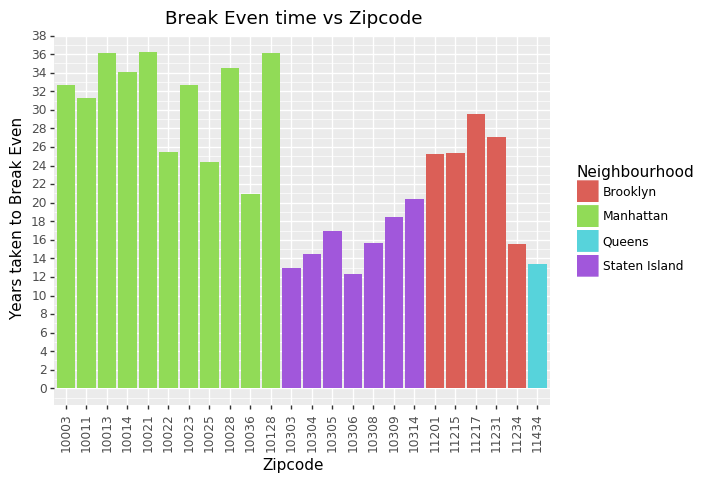

<ggplot: (326775513)>

In [23]:
df_beven = final.groupby('zipcode').aggregate({'breakeven_yrs' : max, 'Neighbourhood': max}).reset_index()
df_beven['zipcode'] = df_beven.zipcode.astype(str)
ggplot(data = df_beven, mapping = aes(x = 'zipcode', y = 'breakeven_yrs', fill ='Neighbourhood')) +\
geom_bar(stat = 'identity')+\
theme(axis_text_x=element_text(rotation=90, hjust=2))+\
labs(x = 'Zipcode', y = 'Years taken to Break Even', title = 'Break Even time vs Zipcode') +\
scale_y_continuous(breaks=range(0, 50, 2))


In [24]:
pd.DataFrame(df_beven.groupby('Neighbourhood').breakeven_yrs.describe())[['mean','min','max','count']].round(1).style.background_gradient(cmap='Blues',axis= 0)

,mean,min,max,count
Neighbourhood,,,,
Brooklyn,24.6,15.6,29.6,5
Manhattan,31.3,20.9,36.2,11
Queens,13.4,13.4,13.4,1
Staten Island,15.9,12.3,20.4,7


Above is the breakeven time in years w.r.t the neighbourhood

#### Insights

Breakeve time ranges from 12 to 36 years, with mean at 24 years.
Break even time for Manhattan is maximum, followed by Brooklyn, Staten and Queens

### Count of AirBnB listings vs Zipcode

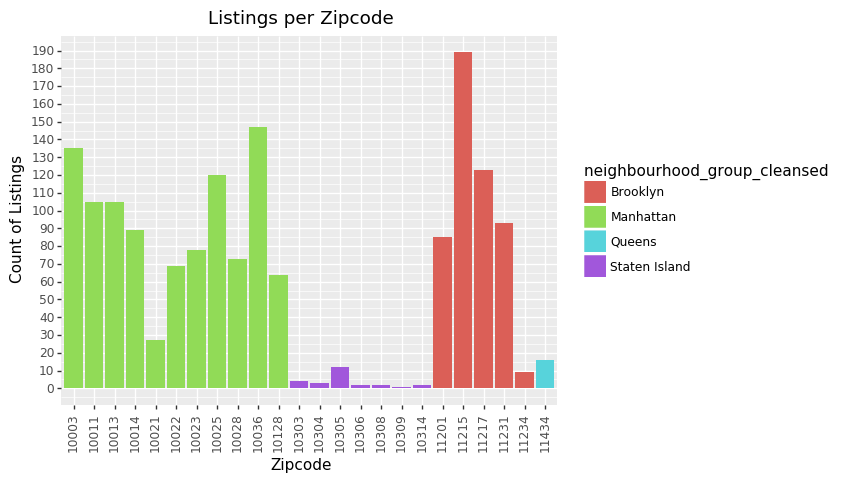

<ggplot: (309442977)>

In [25]:
final_bnb['zipcode'] = final_bnb['zipcode'].astype('str')
p = ggplot(data = final_bnb,mapping =  aes(x = 'zipcode', fill = 'neighbourhood_group_cleansed ')) + geom_bar() 
p + theme(axis_text_x=element_text(rotation=90, hjust=2))+\
labs(x="Zipcode",
     y="Count of Listings", title = 'Listings per Zipcode') +\
scale_y_continuous(breaks=range(0, 200, 10))
#rename legend

Its important to see number of listings in the zipcode because we have approximated the median rent from the given sample listings.\
It will be a poor approximation if listings per zipcode are less. For the purpose of profitability lets consider zipcodes with atleast minimum number of listings.

**Define Minimum Listings below:**

In [26]:
#Define Variable
min_listings = 4 # Type- integer. Since we need median price for BnB listings, having cut off for minimum sample size

## Profitability

**Its defined as the cummulative revenue from the rent post the breakeven time.**\
Note- We have taken rent to be increasing at a compounded interest post 2019

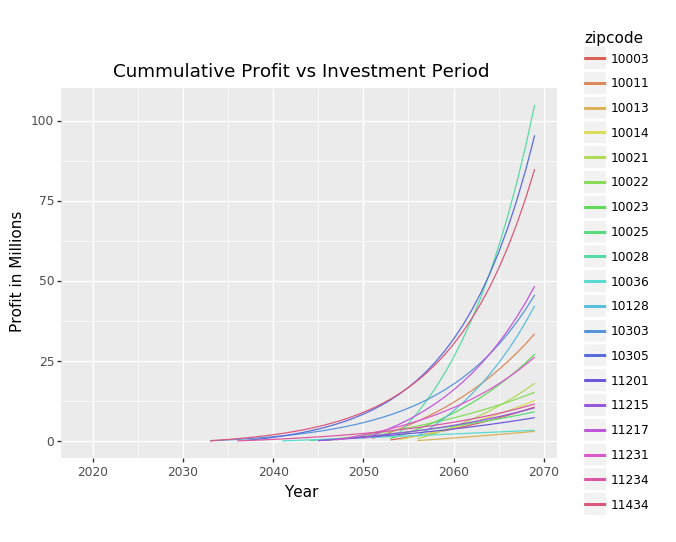

<ggplot: (330089577)>

In [27]:
pr_final = final.loc[final['listings'] >= min_listings]
pr_final['zipcode'] = pr_final.zipcode.astype(str)
pr_final['cum_profit'] = pr_final.cum_profit/1000000

ggplot(pr_final)+geom_line(aes(x= 'rent_yr', y = 'cum_profit', color = 'zipcode'))+\
labs(x="Year",
     y="Profit in Millions", title = 'Cummulative Profit vs Investment Period') +\
scale_x_continuous(breaks=range(2020, 2090, 10))

#### Insights
**Above is an interesting graph. It shows how return period plays an important role in defining profits.
Although some zipcodes achieve an early break even, in long run cummulative profit from them may not be large.** 

Lets calculate cummulative profits for all zipcodes for return period of 2019-2070.

### Choose your investment Window

In [28]:
final2 = pr_final.loc[((pr_final.rent_yr > min(pr_final.break_even_yr)) & (pr_final.rent_yr % 2 == 0)), ]
pd.crosstab(final2.zipcode, final2.rent_yr, values = final2.cum_profit, aggfunc = 'sum').round(1).style.background_gradient(cmap='Blues',axis =0)

rent_yr,2034,2036,2038,2040,2042,2044,2046,2048,2050,2052,2054,2056,2058,2060,2062,2064,2066,2068
zipcode,,,,,,,,,,,,,,,,,,
10003,0,0,0,0,0,0,0,0,0,0,0.8,1.7,2.8,3.9,5.1,6.5,8,9.8
10011,0,0,0,0,0,0,0,0,0,1.8,3.8,6.2,9,12.1,15.8,20,24.8,30.4
10013,0,0,0,0,0,0,0,0,0,0,0,0.2,0.6,1,1.4,1.9,2.3,2.8
10014,0,0,0,0,0,0,0,0,0,0,0.5,1.6,2.9,4.3,5.8,7.5,9.4,11.6
10021,0,0,0,0,0,0,0,0,0,0,0,0.8,2.5,4.5,6.8,9.5,12.5,16.1
10022,0,0,0,0,0,0,0.3,1,1.8,2.7,3.7,4.8,6,7.3,8.7,10.4,12.2,14.2
10023,0,0,0,0,0,0,0,0,0,0,1.7,3.8,6.1,8.8,11.9,15.5,19.7,24.5
10025,0,0,0,0,0,0.2,0.6,1,1.5,2.1,2.6,3.3,4,4.7,5.6,6.5,7.5,8.6
10028,0,0,0,0,0,0,0,0,0,0,2.7,8.9,16.6,26.1,37.8,52.3,70.1,92.1


**Above profits are in million.\
0 means the breakeven is still not achieved.**

# Findings

**1. Zipcode - 10303,11434 achieves the earliest break even**\
**2. Return on 10303 are not promising whereas 11434 (Queens) are very promising**\
**3. If the return period is less than 35 years zipcode- 11434 and 10305 are most promising**\
**4. Zipcode - 10028 achieves a break even in 2053 but has the most promising returns in long term**

Note- we have filtered out zipcode with less than 4 listings for above findings. 

# Conclusion

1. Properties in Queens and States Island are cheaper and have early break even time.
2. Manhattan is most expensive, has longer break-even period but some zipcodes have very promising long term results. 
3. Zipcode - 11434 (Queens) is a good investment for a return period of less than 35 years
4. For return period of more than 35 and enough investment capital, zipcode 10028 is certainly the best area to invest


- Note we have not calculated return% w.r.t to the incvestment amount, because there would also be the capital increase in the property which could compensate the opportunity cost(interest) uptill the break-even period. 

# Future work

1. A more robust method can be used to arrive at median rents w.r.t the zipcodes. Here, we have taken median of the given sample listings as the median rent in that zipcode, which may not be a good approximation given a small sample size.
2. AirBnb Listings contain different apratment types, whose rents vary significantly. Thus apartment type should be filtered based on how zillow data is collected. 
3. Rents and occupancy are subject to seasonlaity, which we have not captured in the data but is a crucial component of the model. 
4. Other informations like SizeRank in zillow data can be used to prioritize between zipcodes with similar returns.
5. Parameters like area, bathrooms, guest, amenities etc, provided in AirBnB data should also be considered to forecast demand and thus prioritize listings.
7. Property prices have historically increased over time, thus 'profit' can also take into account the possible captial gains. 